# HCI 2017 Final Exam

*Matthew Kenworthy // Leiden Observatory*

This is the final exam for the HCI 2017 course.

There are four data cubes that contain the image of an exoplanet, named ``c01.fits.gz`` through to ``c04.fits.gz``.

Answer the questions fully in English in a cell after the question. There are 10 points in total on this exam.

You must email this Notebook with YOUR_NAME replaced with your name and emailed to ``quiroganunez@strw.leidenuniv.nl``

### DEADLINE IS 11:59 on TUESDAY 12 DECEMBER

  * The notebook **must compile cleanly** (``Cell => All Output=> Clear`` and then ``Cell => Run All`` must produce all your graphs and plots and images without an error) and should contain all subroutines required for data reduction.
  
##  If the Notebook does **NOT** complile cleanly, you will LOSE MARKS on this Final Exam.

  * All graphs and plots **MUST** be labelled with quantities and units.
  
  
**Q1 (1 point)** What diversity is being used in this data?

In [ ]:
'''As can be seen from the data cubes with DS9 the diversity being used is Spectral. 
The speckles depend linearly on the wavelength, so this will helps us out to subtract
them without affecting the star's and planet's PSFs repectively.'''

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, clobber=True)
    
    
def cen_scale (im, sca, dim_out, offset_in=(0,0), offset_out=(0,0), order=2):
    """cen_scale - scales image im at the coordinates of offset1 by factor sca
                   to output image with size dim_out, and puts the point at offset1 
                   in the centre of the output image, with an optional delta offset of offset2
                
                """
    from scipy.ndimage import affine_transform
    # make a scaling matrix
    scale=np.array([[1./sca,0],[0,1./sca]])
    
    # -0.5 is there for fencepost counting error
    c_in = np.array(offset_in) - 0.5

    # c_out already starts at the centre of the output image
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-scaled to make offset correct
    offset_combined = c_in - c_out.dot(scale) - np.array(offset_out).dot(scale)
    
    # perform the transformation
    dst=affine_transform( \
        im,scale.T, order=order, offset=offset_combined, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def descale(imin, scalefac, out_dims, star_cen):
    """descale - take image imin and a list of magnifications scalefac, and generate an output image of 
       size outdims (where outdims is a tuple) and the scaling is done around the point star_cen.
       star_cen is a tuple of (xstar, ystar) positions and 
       xstar/ystar should be a numpy array or a numpy single value"""
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # sx and sy should be a single pair or contain scalefac.size number of elements
    sx, sy = star_cen
    if (sx.size == 1):
        sx = np.ones_like(scalefac) * sx
    if (sy.size == 1):
        sy = np.ones_like(scalefac) * sy
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_scale(frame_sq, scalefac[j], out_dims, offset_in=(sx[j], sy[j]))
        im_out[j,:,:] = frame_rot
        
    return(im_out)   

**Q2 (2 points)** Analyse ``c01.fits.gz`` using one of the algorithms covered in the course and produce a data cube with images that are 250 by 250 pixels with the central star in the centre of the image. 

Print out the `shape()` of the data cube to show that you have the correct dimensions.

In [69]:
Im_1, He_1 = fits.getdata('c01.fits.gz', header = True) #Data cubes containing the exoplanet
Im_2, He_2 = fits.getdata('c02.fits.gz', header = True)
Im_3, He_3 = fits.getdata('c03.fits.gz', header = True)
Im_4, He_4 = fits.getdata('c04.fits.gz', header = True)

Im_1 = np.nan_to_num(Im_1) #Avoiding NAN-values in the images
Im_2 = np.nan_to_num(Im_2)
Im_3 = np.nan_to_num(Im_3)
Im_4 = np.nan_to_num(Im_4)

print(Im_1.shape)
He_1

(37, 281, 281)


XTENSION= 'IMAGE   '           /  C# FITS: 12/10/2013 2:43:33 AM                
BITPIX  =                  -32                                                  
NAXIS   =                    3 /                                                
NAXIS1  =                  281 /                                                
NAXIS2  =                  281 /                                                
NAXIS3  =                   37 /                                                
PCOUNT  =                    0 / No extra parameters                            
GCOUNT  =                    1 / One group                                      
CD1_1   =    2.59842775856E-06 / partial of first axis coordinate w.r.t. x      
CD1_2   =   -3.00445045994E-06 / partial of first axis coordinate w.r.t. y      
CD2_1   =    3.00445045994E-06 / partial of second axis coordinate w.r.t. x     
CD2_2   =    2.59842775856E-06 / partial of second axis coordinate w.r.t. y     
CDELT1  =               0.00

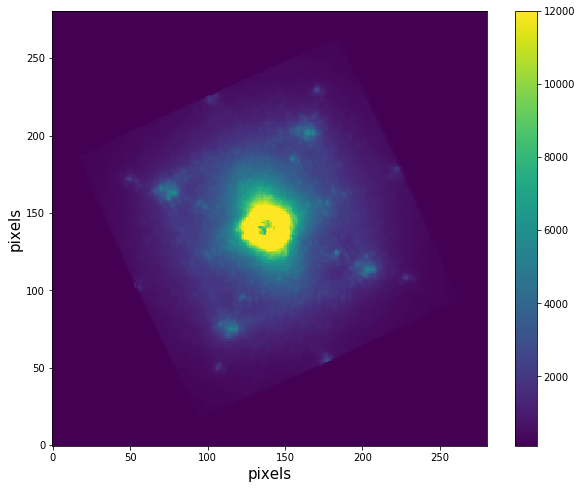

In [70]:
plt.figure(figsize = (10,8))
plt.imshow(Im_1[12], vmin = 100, vmax = 12000, cmap = 'viridis') 
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.colorbar()

Spot 0, (X,Y) (98.423000, 154.243000)
Spot 1, (X,Y) (122.409000, 95.720000)
Spot 2, (X,Y) (154.966000, 184.910000)
Spot 3, (X,Y) (183.351000, 124.298000)


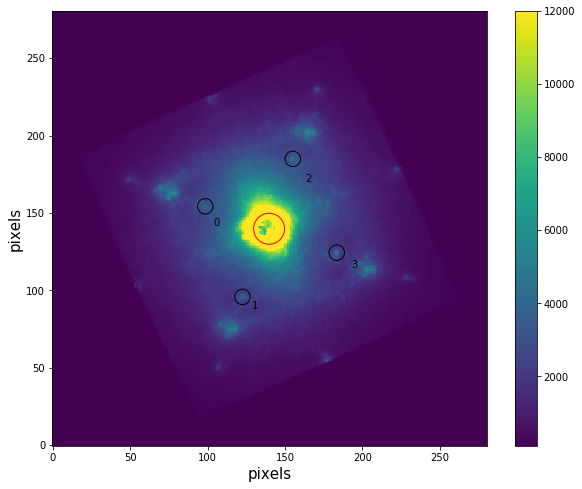

In [71]:
plt.figure(figsize = (10,8))

X_star = He_1['PSFCENTX']
Y_star = He_1['PSFCENTY']

for i in range(4):
    #print(he['SATS12_%d'%i])
    [X,Y] = np.fromstring(He_1['SATS12_%d'%i], dtype = float, sep = ' ')
    print('Spot %i, (X,Y) (%f, %f)'%(i,X,Y))
    
    Circle = plt.Circle((X, Y), 5, color = 'k', fill = False)
    Star   = plt.Circle((X_star, Y_star), 10, color = 'r', fill = False)
    ax = plt.gca()
    #A = ax.imshow(im[12], vmin = 0, vmax = 100)
    A = ax.imshow(Im_1[12], vmin = 100, vmax = 12000)
    ax.add_artist(Circle)
    ax.text(X + 0.05*X, Y - 0.08*Y, '%d'%i, color = 'k')
    
ax.add_artist(Star)
ax.set_xlabel('pixels', size = 15)
ax.set_ylabel('pixels', size = 15)
plt.colorbar(A, ax = ax);

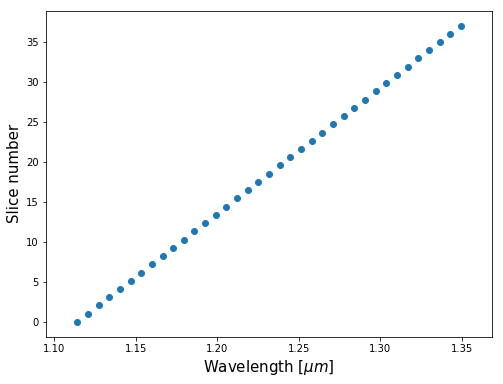

In [72]:
wlen0 = He_1['CRVAL3']
dwlen = He_1['CD3_3']
#print(wlen0);print(dwlen)

Slice_number = np.linspace(0, 37, 37)
Wavelength = []
for i in range(37):
    Wavelength.append(wlen0 + dwlen*i)
    
Wavelength = np.array(Wavelength)

plt.figure(figsize = (8, 6))    
plt.scatter(Wavelength, Slice_number)
plt.ylabel('Slice number', size = 15)
plt.xlabel(r'Wavelength [$\mu m$]', size = 15);

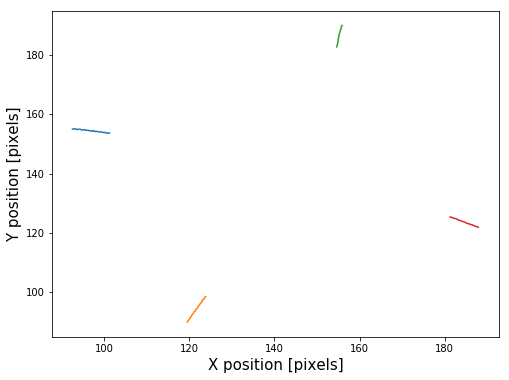

In [73]:
def sat_spot_read(He_1):
    # SATSn_m with n from 0 to 36 and m from 1 to 4
    ns = 4
    nw = 37
    
    spotx = np.zeros((nw, ns))
    spoty = np.zeros((nw, ns))
    
    for i in range(nw):
        
        for j in range(ns):
            
            X, Y = np.fromstring(He_1['SATS%d_%d'%(i,j)], dtype = float, sep = ' ')
            spotx[i][j] = X
            spoty[i][j] = Y
    
    # Q5 answer here
    return(spotx, spoty)

x, y = sat_spot_read(He_1)  

# Q6 answer here
plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.xlabel('X position [pixels]', size = 15)
plt.ylabel( 'Y position [pixels]', size = 15);

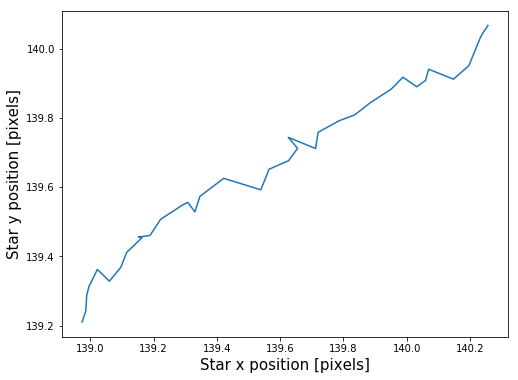

In [74]:
star_xcen = []
star_ycen = []

for i in range(37):
    
    #star_xcen.append( x[i][0] + ( x[i][2] - x[i][0] ) / 2.0 )
    #star_ycen.append( y[i][0] + ( y[i][2] - y[i][0] ) / 2.0 )
    
    star_xcen.append(np.mean([x[i][0], x[i][1], x[i][2], x[i][3]]))
    star_ycen.append(np.mean([y[i][0], y[i][1], y[i][2], y[i][3]]))
    
star_xcen = np.array(star_xcen)
star_ycen = np.array(star_ycen) 

plt.figure(figsize = (8, 6))
plt.plot(star_xcen, star_ycen)
plt.xlabel('Star x position [pixels]', size = 15)
plt.ylabel('Star y position [pixels]', size = 15);

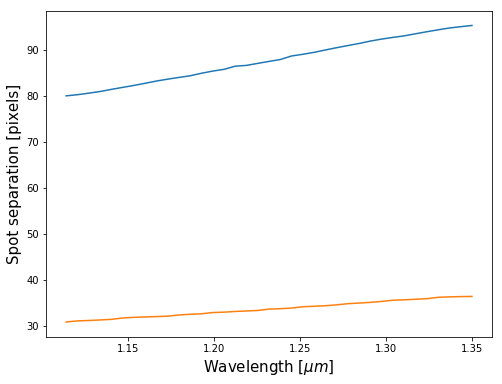

In [75]:
spot_separation_1 = []
spot_separation_2 = []

for i in range(37):
    
    spot_separation_1.append(x[i][3] - x[i][0])
    spot_separation_2.append(x[i][2] - x[i][1])
    
spot_separation_1 = np.array(spot_separation_1)  
spot_separation_2 = np.array(spot_separation_2)

plt.figure(figsize = (8, 6))
plt.plot(Wavelength, spot_separation_1)
plt.plot(Wavelength, spot_separation_2)
plt.xlabel(r'Wavelength [$\mu m$]', size = 15)
plt.ylabel('Spot separation [pixels]', size = 15);

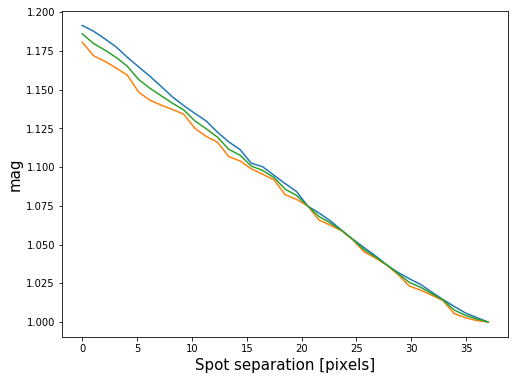

In [64]:
mag_1 = spot_separation_1[-1] / spot_separation_1
mag_2 = spot_separation_2[-1] / spot_separation_2

Med_mag = []
for i in range(len(mag_1)):
    Med_mag.append(np.median([mag_1[i], mag_2[i]]))
    
Med_mag = np.array(Med_mag)

plt.figure(figsize = (8, 6))
plt.plot(Slice_number, mag_1)
plt.plot(Slice_number, mag_2)
plt.plot(Slice_number, Med_mag)
plt.ylabel('mag', size = 15)
plt.xlabel('Spot separation [pixels]', size = 15);

In [65]:
scalefac = Med_mag
out_dims = (250, 250)
star_cen = (star_ycen, star_xcen)

sdi1 = descale(Im_1, scalefac, out_dims, star_cen)
wfits(sdi1, 'sdi1_cube.fits')

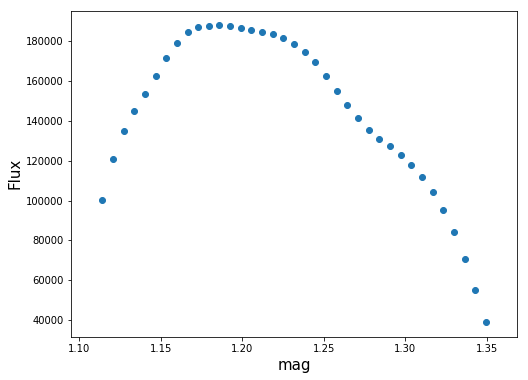

In [66]:
Im_1, He_1 = fits.getdata('sdi1_cube.fits', header = True)
Im_1 = np.nan_to_num(Im_1)

spot_sum = []

for i in range(37):
    
    spot_sum.append(np.sum(Im_1[i][108-5:108+5,174-5:174+5])) 
    
spot_sum = np.array(spot_sum)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux', size = 15);

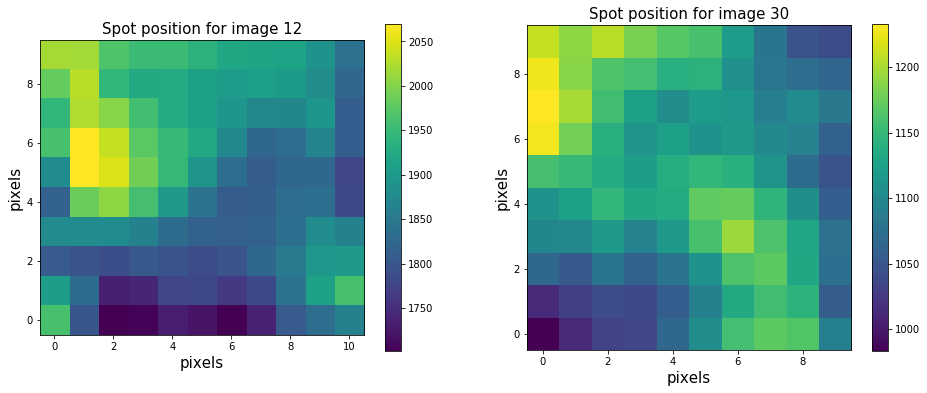

In [67]:
#Sanity check: The spots should remain in the same box position in different images

fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), ncols = 2, nrows = 1)

A = axA.imshow(Im_1[12][108-5:108+5,174-5:175+5])
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.set_title('Spot position for image 12', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(Im_1[30][108-5:108+5,174-5:174+5])
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('Spot position for image 30', size = 15)
plt.colorbar(B, ax = axB)

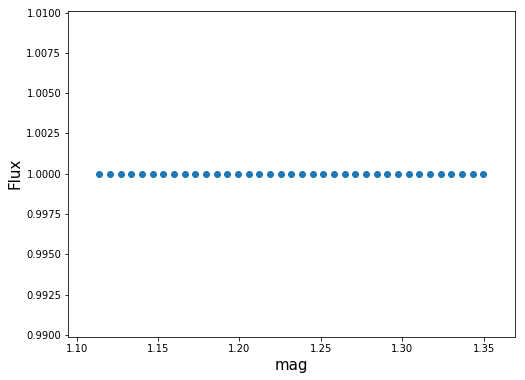

In [59]:
sdi1_norm = []

for i in range(37):
    sdi1_norm.append(Im_1[i] / spot_sum[i])
    
wfits(sdi1_norm, 'sdi1_norm_cube.fits')

sdi1_norm = np.array(sdi1_norm)

#Sanity check for the normalization
spot_sum_2 = []
 
for i in range(37):
    
    spot_sum_2.append(np.sum(sdi1_norm[i][108-5:108+5,174-5:174+5])) 
    
spot_sum_2 = np.array(spot_sum_2)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum_2);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux', size = 15);

In [62]:
Median          = np.median(sdi1_norm, axis = 0)
sdi1_norm_sub_2 = np.array(sdi1_norm - Median)

sdi1_norm_sub = []

for i in range(37):
    sdi1_norm_sub.append(sdi1_norm_sub_2[i] * spot_sum[i])
    
sdi1_norm_sub = np.array(sdi1_norm_sub)

In [63]:
scalefac = 1.0 / Med_mag
out_dims = (250, 250)
star_cen = (np.array(125), np.array(125))

sdi_out = descale(sdi1_norm_sub, scalefac, out_dims, star_cen)
wfits(sdi_out, 'sdi_out.fits')

TypeError: unsupported operand type(s) for /: 'float' and 'list'

**Q3 (1 point)** Collapse the data cube along the third dimension to make a 2D square image. Pick a display range in intensity that shows the planet, and draw a green circle around the location of the planet.

**Q4 (1 point)** Determine the angular separation in pixels between the planet and star to an accuracy of 1 pixel. Print out this distance using a formatted print statement.

**Q5 (1 point)** Assuming a pixel scale of $14.3\pm 0.1$ milliarcsec per pixel, determine the angular separation of the planet in arcseconds with an appropriate quoted error. Print using a formatted print statement.

**Q6 (1 point)** Measure the flux of the planet using an aperture that is 100 milliarcseconds in diameter and centered on the planet. Print using a formatted print statement. 

Remember to estimate the sky background using a similar sized aperture at the same angular distance from the star but close to the location of the planet. 

Print the r.m.s. per pixel in the sky background aperture, and print the planet flux corrected for the sky background level.

**Q7 (3 points)** Reduce the other 3 data cubes, and combine the 4 individual images to form a final higher signal to noise image, and display it with `imshow()` to show the planet. Estimate the total flux and error on the flux of the planet using the same sized apertures used earlier. 

Use the variance in these fluxes to estimate the signal to noise of the final combined image. Print out the total flux of the planet with an error to two decimal planes.